# Punch-through RC slab test

In [1]:
from ibvpy.bcond import BCSlice
from ibvpy.fets import FETS2D4Q
from ibvpy.tmodel.mats3D import MATS3DElastic, MATS3DScalarDamage
from ibvpy.tmodel.viz3d_scalar_field import \
    Vis3DStateField, Viz3DScalarField
from ibvpy.tmodel.viz3d_tensor_field import \
    Vis3DTensorField, Viz3DTensorField
from mayavi import mlab
from ibvpy.sim.tstep_bc import TStepBC
from ibvpy.xmodel.xdomain_fe_grid_axisym import XDomainFEGridAxiSym
import numpy as np
import matplotlib.pylab as plt

print('HI')

IndexError: list index out of range

## Current state 
 * Running with a scalar damage model - unreinforced test without regularization

## Todo 
 * Boundary conditions - normal force at outer boundary must be zero
 * Formulation of a damage function for strain-hardening (no regularization needed then)
 * Algorithmic stiffness might be helpful to accellerate convergence
 * Visualization of damage evolution
 * Add damage as a recorded variable to visualize cracking histories

In [ ]:
from bmcs_expsim.utils.mlab_decorators import decorate_figure

# Grid discretization

In [ ]:
column_span = 5000 # mm
radius = column_span / 2
cross_section_height = 150 # mm
n_elems=(5,20)

xmodel = XDomainFEGridAxiSym(coord_min=(0,0),
                             coord_max=(cross_section_height,radius),
                             shape=n_elems,
                             integ_factor=2 * np.pi,
                             fets=FETS2D4Q())

# Material model

In [ ]:
tmodel = MATS3DScalarDamage(E=28000, nu=0.3, epsilon_0=3.5 / 28000, epsilon_f=100)
tmodel.epsilon_0, tmodel.epsilon_f

# Boundary conditions

In [ ]:
w_max = 4 # mm
bc_fixed_outer_radius = BCSlice(slice=xmodel.mesh[:, -1, :, -1],
                                var='u', dims=[0,1], value=0.0)
bc_ax_sym = BCSlice(slice=xmodel.mesh[:, 0, :, 0],
                      var='u', dims=[1], value=0)
bc_column_load = BCSlice(slice=xmodel.mesh[0, 0, 0, 0],
                     var='u', dims=[0], value=w_max)

# Time stepping model 

In [ ]:
m = TStepBC(
    domains=[(xmodel, tmodel)],
    bc=[bc_ax_sym, bc_fixed_outer_radius, bc_column_load] # , bc_r_y],
)

m.hist.vis_record = {
    'strain': Vis3DTensorField(var='eps_ab'),
    # 'stress': Vis3DTensorField(var='sig_ab'),
    # 'damage': Vis3DStateField(var='omega'),
    #        'kinematic hardening': Vis3DStateField(var='z_a')
}

In [ ]:
w_steps = 50
s = m.sim
s.tloop.k_max = 400
s.tline.step = 1 / w_steps
s.tloop.verbose = True
s.run()

# Access the full history of nodal forces and displacements

`t` denotes the time index and `o` the degree of freedom.

In [8]:
F_to = m.hist.F_t
U_to = m.hist.U_t

In [9]:
F_r_t = np.sum(F_to[:, bc_column_load.dofs], axis=-1)
U_r_t = np.average(U_to[:, bc_column_load.dofs], axis=-1)

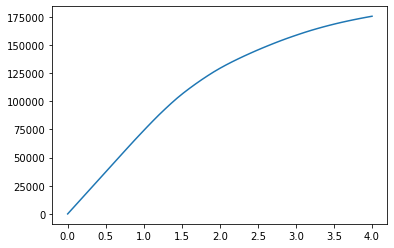

In [10]:
_, ax = plt.subplots(1,1)
ax.plot(U_r_t, F_r_t)

In [11]:

#mlab.options.backend = 'envisage'

f_strain = mlab.figure()
scene = mlab.get_engine().scenes[-1]
scene.name = 'strain'
strain_viz = Viz3DTensorField(vis3d=m.hist['strain'])
strain_viz.setup()

decorate_figure(f_strain, strain_viz, 200, [70, 20, 0])

# f_stress = mlab.figure()
# scene = mlab.get_engine().scenes[-1]
# scene.name = 'stress'
# stress_viz = Viz3DTensorField(vis3d=m.hist['stress'])
# stress_viz.setup()
#
# decorate_figure(f_stress, stress_viz, 200, [70, 20, 0])

mlab.show()